## 2022 EY Challenge - Weather Data

This notebook is used to create a weather dataset from <b>"TerraClimate"</b>. These data parameters, or their variability, can be used as "predictor variables" to relate to species samples. TerraClimate is a dataset of monthly climate and climatic water balance for global terrestrial surfaces from 1958-2019. These data provide important inputs for ecological and hydrological studies at global scales that require high spatial resolution and time-varying data. All data have monthly temporal resolution and a 4-km (0.036 degree) spatial resolution. The data can be found in the MS Planetary Computer catalog: https://planetarycomputer.microsoft.com/dataset/terraclimate

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rasterio.features
import folium
import math

# Import Planetary Computer tools
import pystac_client
import planetary_computer

### Define the analysis region and view on a map

First, we define our area of interest using latitude and longitude coordinates. Our test region is near Richmond, NSW, Australia. The first line defines the lower-left corner of the bounding box and the second line defines the upper-right corner of the bounding box. GeoJSON format uses a specific order: (longitude, latitude), so be careful when entering the coordinates.

In [2]:
# Define the bounding box using corners
min_lon, min_lat = (150.62, -33.69)  # Lower-left corner (longitude, latitude)
max_lon, max_lat = (150.83, -33.48)  # Upper-right corner (longitude, latitude)

In [3]:
bbox = (min_lon, min_lat, max_lon, max_lat)
latitude = (min_lat, max_lat)
longitude = (min_lon, max_lon)

In [4]:
def _degree_to_zoom_level(l1, l2, margin = 0.0):
    
    degree = abs(l1 - l2) * (1 + margin)
    zoom_level_int = 0
    if degree != 0:
        zoom_level_float = math.log(360/degree)/math.log(2)
        zoom_level_int = int(zoom_level_float)
    else:
        zoom_level_int = 18
    return zoom_level_int

def display_map(latitude = None, longitude = None):

    margin = -0.5
    zoom_bias = 0
    lat_zoom_level = _degree_to_zoom_level(margin = margin, *latitude ) + zoom_bias
    lon_zoom_level = _degree_to_zoom_level(margin = margin, *longitude) + zoom_bias
    zoom_level = min(lat_zoom_level, lon_zoom_level) 
    center = [np.mean(latitude), np.mean(longitude)]
    
    map_hybrid = folium.Map(location=center,zoom_start=zoom_level, 
        tiles=" http://mt1.google.com/vt/lyrs=y&z={z}&x={x}&y={y}",attr="Google")
    
    line_segments = [(latitude[0],longitude[0]),(latitude[0],longitude[1]),
                     (latitude[1],longitude[1]),(latitude[1],longitude[0]),
                     (latitude[0],longitude[0])]
    
    map_hybrid.add_child(folium.features.PolyLine(locations=line_segments,color='red',opacity=0.8))
    map_hybrid.add_child(folium.features.LatLngPopup())        

    return map_hybrid

In [5]:
# Plot bounding box on a map
f = folium.Figure(width=600, height=600)
m = display_map(latitude,longitude)
f.add_child(m)

### Discover and load the data for analysis

Using <b>pystac</b>, we will load the collection with links to all of the metadata about this dataset. The collection contains assets, which are links to the root of a Zarr store, which can be opened with xarray. Once loaded and opened, we can select the parameters we desire for further analyses. Overall, there are 18 variables for consideration. You can click the "Data Variables" output "arrow" for a list of those parameters.

In [6]:
import pystac
collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
asset = collection.assets["zarr-https"]

In [7]:
import fsspec
import xarray as xr

store = fsspec.get_mapper(asset.href)
data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])

In [8]:
# View the dimensions, coordinates and variables of the dataset
# Click on the "data variables" arrow to expand the output and see all of the possible variables
data

,Array,Chunk
Bytes,103.45 GiB,94.92 MiB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,103.45 GiB,94.92 MiB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


### Parsing the dataset

Assuming we do not need all 18 variables and global coverage, we will "clip" the data to our region and select a time window that is representative of weather over this area (e.g. 5 years). Finally, we will select the variables we think are most likely to be "predictor variables" for frog species habitats. These are:<br> 
<br>maximum air temperature (tmax) - 2 meters above surface
<br>minimum air temperature (tmin) - 2 meters above surface
<br>accumulated precipitation (ppt) - accumulated monthly in millimeters
<br>soil moisture (soil) - soil moisture in millimeters at end of month

In [9]:
clipped_data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice('2015-01-01','2019-12-31'))

In [10]:
parsed_data = clipped_data[['tmax', 'tmin', 'ppt', 'soil']]

In [18]:
# View the dimensions: time is in months, lat/lon is in pixels
# View the coordinates: lat, lon and time
# View the data variables we have parsed from the overall dataset
parsed_data

<xarray.Dataset>
Dimensions:  (time: 60, lat: 5, lon: 5)
Coordinates:
  * lat      (lat) float64 -33.52 -33.56 -33.6 -33.65 -33.69
  * lon      (lon) float64 150.6 150.7 150.7 150.8 150.8
  * time     (time) datetime64[ns] 2015-01-01 2015-02-01 ... 2019-12-01
Data variables:
    tmax     (time, lat, lon) float32 dask.array<chunksize=(12, 5, 5), meta=np.ndarray>
    tmin     (time, lat, lon) float32 dask.array<chunksize=(12, 5, 5), meta=np.ndarray>
    ppt      (time, lat, lon) float32 dask.array<chunksize=(12, 5, 5), meta=np.ndarray>
    soil     (time, lat, lon) float32 dask.array<chunksize=(12, 5, 5), meta=np.ndarray>

### Data Analysis
Now we will look closer at some of this data using plotting and statistics.

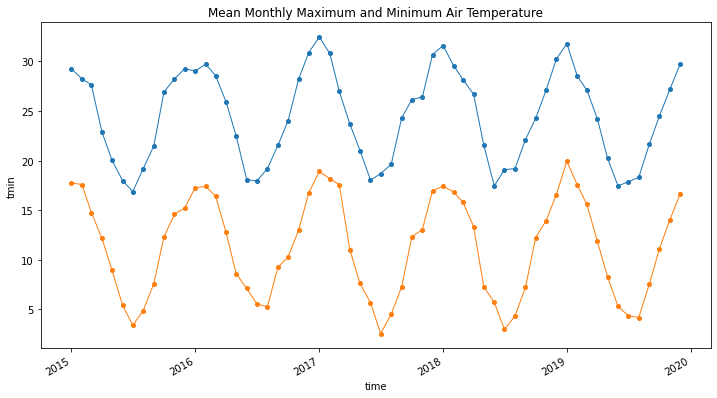

In [12]:
fig = plt.figure(figsize=(12, 6))
parsed_data["tmax"].mean(dim=["lat","lon"]).plot(marker='o',markersize=4,linewidth=1)
parsed_data["tmin"].mean(dim=["lat","lon"]).plot(marker='o',markersize=4,linewidth=1)
plt.title("Mean Monthly Maximum and Minimum Air Temperature")
plt.show()

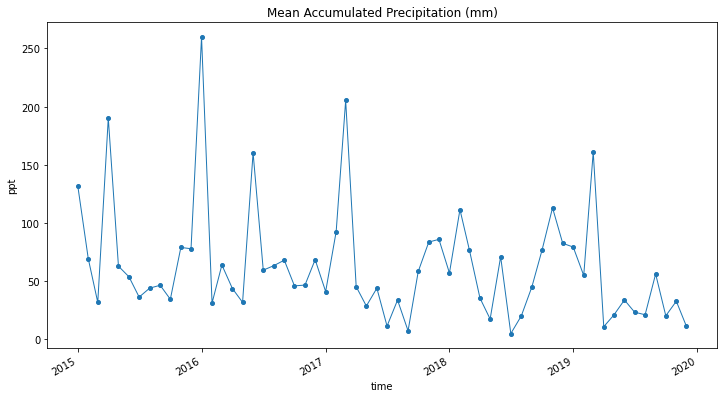

In [13]:
# Precipitation
precip = (parsed_data["ppt"]).mean(dim=["lat","lon"])
precip.plot(figsize=(12, 6),marker='o',markersize=4,linewidth=1)
plt.title("Mean Accumulated Precipitation (mm)")
plt.show()

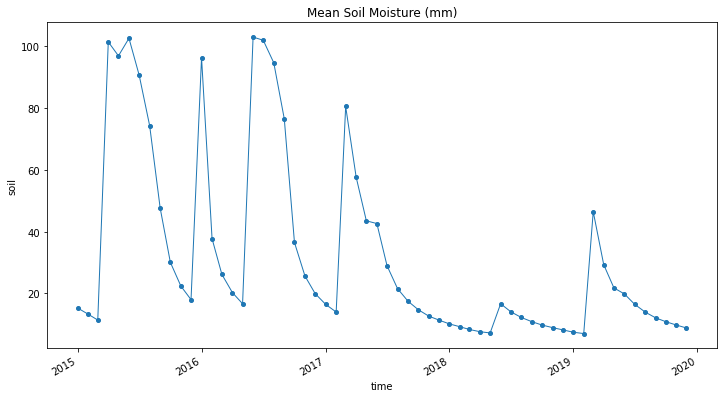

In [14]:
# Soil Moisture
moisture = (parsed_data["soil"]).mean(dim=["lat","lon"])
moisture.plot(figsize=(12, 6),marker='o',markersize=4,linewidth=1)
plt.title("Mean Soil Moisture (mm)")
plt.show()

### How will the participants use this data?
The GeoTIFF file will contain the Lat-Lon coordinates of each pixel and will also contain the selected parameters for each pixel as separate data layers. Since the FrogID data is also Lat-Lon position, it is possible to find the closest pixel using code similar to what is demonstrated below. Once this pixel is found, then the corresponding parameter data values can be used for modeling species distribution. One example is to use the long-term mean values of a given parameter for a particular location and use that value for species modeling. Below are some sample results for a random Lat-Lon location.

In [15]:
val_maxtemp = parsed_data.tmax.mean(dim=["time"]).sel(lon=150.71, lat=-33.51, method="nearest").values    
print("This is the mean maximum air temperature for the closest pixel: ", np.round(val_maxtemp,1))
val_allmaxtemp = parsed_data.tmax.max(dim=["time"]).sel(lon=150.71, lat=-33.51, method="nearest").values    
print("This is the overall maximum air temperature for the closest pixel: ", np.round(val_allmaxtemp,1))
val_mintemp = parsed_data.tmin.mean(dim=["time"]).sel(lon=150.71, lat=-33.51, method="nearest").values    
print("This is the mean minimum air temperature for the closest pixel: ", np.round(val_mintemp,1))
val_allmintemp = parsed_data.tmin.min(dim=["time"]).sel(lon=150.71, lat=-33.51, method="nearest").values    
print("This is the overall minimum air temperature for the closest pixel: ", np.round(val_allmintemp,1))
val_precip = parsed_data.ppt.mean(dim=["time"]).sel(lon=150.71, lat=-33.51, method="nearest").values    
print("This is the mean accumulated precipitation for the closest pixel: ", np.round(val_precip,1))
val_soil = parsed_data.soil.mean(dim=["time"]).sel(lon=150.71, lat=-33.51, method="nearest").values    
print("This is the mean soil moisture for the closest pixel: ", np.round(val_soil,1))

This is the mean maximum air temperature for the closest pixel:  24.4
This is the overall maximum air temperature for the closest pixel:  32.4
This is the mean minimum air temperature for the closest pixel:  11.2
This is the overall minimum air temperature for the closest pixel:  2.6
This is the mean accumulated precipitation for the closest pixel:  62.5
This is the mean soil moisture for the closest pixel:  31.0


### Saving the time series data in CSV format
Now, what if you want to save the time series data for a particular parameter and Lat-Lon location? We can use the example above to specify a Lat-Lon position and then save the time series soil moisture data for that location. Below is the code that will create this CSV file. The file will contain columns for time (month), latitude and longitude (for the nearest pixel) and soil moisture. 

In [16]:
filename = "Soil_Moisture_sample.csv"
parsed_data["soil"].sel(lon=150.71, lat=-33.51, method="nearest").to_dataframe().to_csv(filename)

In [17]:
# Show the location and size of the new output file
!ls *.csv -lah

-rw-rw-r-- 1 jovyan users 3.3K Jan 21 18:34 Soil_Moisture_sample.csv
